In [2]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf


/Users/stefansrjakovferi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# 2. Parameters
DATA_PATH = "Data/genres_original"
SAMPLE_RATE = 22050
DURATION = 3   # segment length in seconds
SAMPLES_PER_SEGMENT = SAMPLE_RATE * DURATION
N_MELS = 128


In [4]:
# 3. Function to extract Mel-spectrograms from audio
def extract_mel_spectrogram(file_path, n_mels=N_MELS, sr=SAMPLE_RATE, n_fft=2048, hop_length=512):
    signal, sr = librosa.load(file_path, sr=sr)
    # Split audio into multiple segments for augmentation
    num_segments = int(len(signal) / SAMPLES_PER_SEGMENT)
    features = []
    for s in range(num_segments):
        start = s * SAMPLES_PER_SEGMENT
        end = start + SAMPLES_PER_SEGMENT
        segment = signal[start:end]
        if len(segment) == SAMPLES_PER_SEGMENT:
            mel = librosa.feature.melspectrogram(y=segment, sr=sr, n_fft=n_fft,
                                                 hop_length=hop_length, n_mels=n_mels)
            mel_db = librosa.power_to_db(mel, ref=np.max)
            features.append(mel_db)
    return features


In [6]:
import random

# Parameters to control how much you process
MAX_FILES_PER_GENRE = 1000       # e.g., only take up to 50 wavs per genre
FILE_SAMPLE_RATIO = 0.3        # e.g., only 30% of files in that genre
MAX_MELS_PER_FILE = 10          # cap segments per file

genres = os.listdir(DATA_PATH)
X, y = [], []

for genre in genres:
    genre_path = os.path.join(DATA_PATH, genre)
    if os.path.isdir(genre_path):
        files = [f for f in os.listdir(genre_path) if f.endswith(".wav")]
        
        # Optionally shuffle and limit
        random.shuffle(files)
        if FILE_SAMPLE_RATIO < 1.0:
            files = files[: int(len(files) * FILE_SAMPLE_RATIO)]
        if MAX_FILES_PER_GENRE is not None:
            files = files[:MAX_FILES_PER_GENRE]

        for filename in files:
            file_path = os.path.join(genre_path, filename)
            mels = extract_mel_spectrogram(file_path)

            # Limit how many mel segments we take per file
            if MAX_MELS_PER_FILE is not None and len(mels) > MAX_MELS_PER_FILE:
                mels = random.sample(mels, MAX_MELS_PER_FILE)

            for mel in mels:
                X.append(mel)
                y.append(genre)

X = np.array(X)
y = np.array(y)
print(f"Dataset shape: {X.shape}, Labels: {y.shape}")


Dataset shape: (2999, 128, 130), Labels: (2999,)


In [8]:
# 5. Encode labels & reshape input for CNN
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X = X[..., np.newaxis]  # add channel dimension

X_train, X_temp, y_train, y_temp = train_test_split(X, y_categorical, test_size=0.2, stratify=y_categorical, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)


(2399, 128, 130, 1) (300, 128, 130, 1) (300, 128, 130, 1)


In [9]:
# 6. Build custom CNN model
def build_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.3),
        
        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.3),
        
        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.3),
        
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    return model

model = build_cnn(X_train.shape[1:], y_categorical.shape[1])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


/Users/stefansrjakovferi/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 62, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 29, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,518,922 (24.87 MB)

 Trainable params: 6,518,474 (24.87 MB)

 Non-trainable params: 448 (1.75 KB)

In [16]:
# 7. Train model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint("cnn_genre_model2.h5", save_best_only=True, monitor='val_loss')

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=30,
                    batch_size=32,
                    callbacks=[early_stop, checkpoint])


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.9509 - loss: 0.1509

75/75 ━━━━━━━━━━━━━━━━━━━━ 45s 591ms/step - accuracy: 0.9510 - loss: 0.1509 - val_accuracy: 0.7867 - val_loss: 0.8267
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.9554 - loss: 0.1355

75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 545ms/step - accuracy: 0.9554 - loss: 0.1356 - val_accuracy: 0.7933 - val_loss: 0.8229
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 566ms/step - accuracy: 0.9518 - loss: 0.1452 - val_accuracy: 0.7567 - val_loss: 1.0099
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 45s 598ms/step - accuracy: 0.9576 - loss: 0.1352 - val_accuracy: 0.8100 - val_loss: 0.8261
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 50s 670ms/step - accuracy: 0.9567 - loss: 0.1255 - val_accuracy: 0.7600 - val_loss: 1.0598
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 580ms/step - accuracy: 0.9605 - loss: 0.1143 - val_accuracy: 0.7800 - val_loss: 0.8645
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.9653 - loss: 0.1117

75/75 ━━━━━━━━━━━━━━━━━━━━ 52s 691ms/step - accuracy: 0.9653 - loss: 0.1117 - val_accuracy: 0.8300 - val_loss: 0.7409
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 38s 512ms/step - accuracy: 0.9656 - loss: 0.1152 - val_accuracy: 0.8033 - val_loss: 0.8239
Epoch 9/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 557ms/step - accuracy: 0.9712 - loss: 0.0962 - val_accuracy: 0.8067 - val_loss: 0.7804
Epoch 10/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 574ms/step - accuracy: 0.9719 - loss: 0.0985 - val_accuracy: 0.8100 - val_loss: 0.8225
Epoch 11/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 52s 698ms/step - accuracy: 0.9651 - loss: 0.1039 - val_accuracy: 0.8433 - val_loss: 0.7448
Epoch 12/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 48s 634ms/step - accuracy: 0.9682 - loss: 0.0929 - val_accuracy: 0.8067 - val_loss: 0.8288
Epoch 13/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 532ms/step - accuracy: 0.9798 - loss: 0.0727 - val_accuracy: 0.8100 - val_loss: 0.8407
Epoch 14/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 38s 504ms/step - accuracy: 0.9755 - loss: 0.0839 - val_accuracy: 

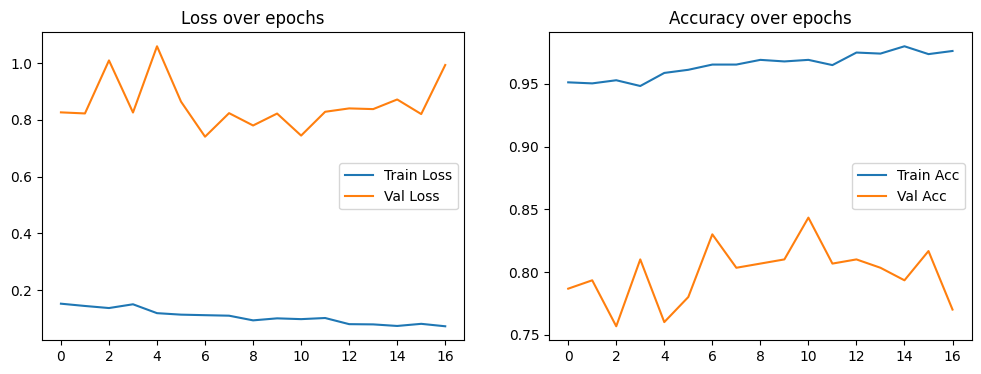

In [17]:
# 8. Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss over epochs")

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()


In [19]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8249 - loss: 0.6997
Test Accuracy: 0.7867


In [20]:
import joblib
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']